In [1]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
sc.settings.n_jobs = 96
sc.set_figure_params(figsize=(4,4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
print ('Run scVI')
import scvi
from rich import print
from scvi.model.utils import mde

Run scVI


/home/ssun1116/.conda/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ssun1116/.conda/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/ssun1116/.conda/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
scvi.settings.seed = 0

Global seed set to 0


In [5]:
import torch
torch.set_float32_matmul_precision("high")
torch.cuda.is_available()

True

In [6]:
torch.cuda.device_count()

3

In [7]:
print(torch.__version__)

2.0.0+cu117

In [8]:
infile = "Input_230907_adata_minFilt_random.h5ad"
# Configure integration
batch_key = "sampleID"
run_date = '230907'
n_hgv = '5000'

In [9]:
adata = sc.read_h5ad(infile)
adata.obs['Dataset'] = adata.obs['Dataset'].astype('category')
adata.obs['Assay'] = adata.obs['Assay'].astype('category')
adata.obs['Library'] = adata.obs['Library'].astype('category')
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata

AnnData object with n_obs × n_vars = 393064 × 49133
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', 'Stage2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets'

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

In [11]:
adata

AnnData object with n_obs × n_vars = 393064 × 49133
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', 'Stage2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets'
    uns: 'log1p'
    layers: 'counts', 'logcounts'

In [12]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=int(n_hgv), flavor="cell_ranger", batch_key=batch_key
)

highly_variable_nbatches
0      20680
1       2764
2       1974
3       1264
4       1214
       ...  
110       15
113       15
107       11
111       11
114        9
Name: count, Length: 115, dtype: int64

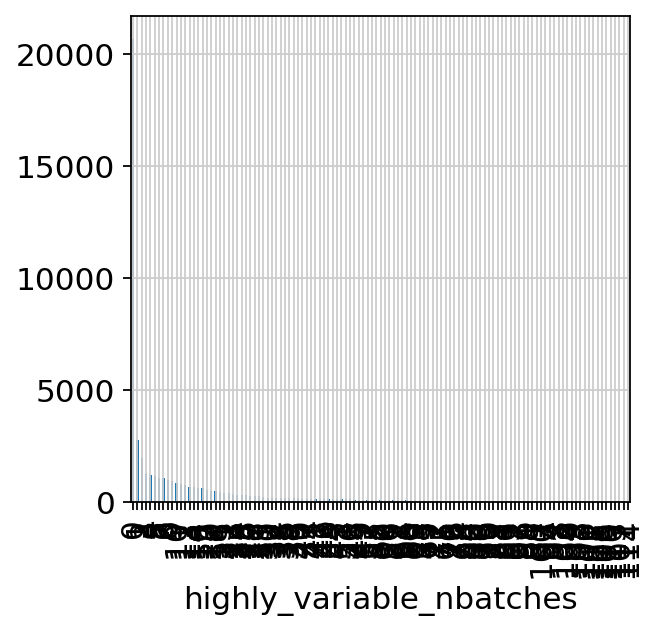

In [13]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [14]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 393064 × 5000
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', 'Stage2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'logcounts'

In [15]:
adata_scvi = adata_hvg.copy()

In [16]:
scvi.model.SCVI.setup_anndata(adata_scvi, 
                              layer="counts", 
                              batch_key=batch_key, 
                              categorical_covariate_keys=["Dataset", "Assay", "Library"])
adata_scvi

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


AnnData object with n_obs × n_vars = 393064 × 5000
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', 'Stage2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'
    layers: 'counts', 'logcounts'

In [17]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [18]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sampleID',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Dataset', 'Assay', 'Library'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │  114   │
│         n_cells          │ 393064 │
│ n_extra_categorical_covs │   3    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                      batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sampleID'] │    10X89_2     │          0          │
│                       │    10X99_5     │          1          │
│                       │    10X99_6     │          2          │
│                       │    10X101_3    │          3          │
│                       │    10X101_7    │          4          │
│                       │    10X102_1    │          5          │
│                       │    10X110_4    │          6          │
│                       │    10X115_5    │          7          │
│                       │    10X115_7    │          8          │
│                       │    10X116_6    │          9          │
│                       │    10X119_2    │         10          │
│                       │    10X119_5    │         11          │
│                       │    10X122_1    │         12          │
│                       │    10X124_3    │         13          │
│                       │    10X124_5    │         14          │
│                       │    10X125_2    │         15          │
│                       │    10X152_2    │         16          │
│                       │    10X152_5    │         17          │
│                       │    10X152_7    │         18          │
│                       │    10X156_2    │         19          │
│                       │    10X163_4    │         20          │
│                       │    10X167_8    │         21          │
│                       │    10X168_1    │         22          │
│                       │    10X168_2    │         23          │
│                       │    10X168_5    │         24          │
│                       │    10X169_1    │         25          │
│                       │    10X169_2    │         26          │
│                       │    10X177_4    │         27          │
│                       │    10X178_5    │         28          │
│                       │    10X185_6    │         29          │
│                       │    10X185_8    │         30          │
│                       │    10X187_2    │         31          │
│                       │    10X187_5    │         32          │
│                       │    10X188_2    │         33          │
│                       │    10X198_3    │         34          │
│                       │    10X199_2    │         35          │
│                       │    10X199_8    │         36          │
│                       │    10X212_5    │         37          │
│                       │    10X212_6    │         38          │
│                       │    10X213_1    │         39          │
│                       │    10X252_3    │         40          │
│                       │    10X252_5    │         41          │
│                       │    10X254_4    │         42          │
│                       │    10X255_2    │         43          │
│                       │    10X287_4    │         44          │
│                       │    10X287_5    │         45          │
│                       │    10X288_6    │         46          │
│                       │    10X302_1    │         47          │
│                       │   510_PFC_B1   │         48          │
│                       │   510_WGE_B1   │         49          │
│                       │   611_PFC_B1   │         50          │
│                       │   611_WGE_B1   │         51          │
│                       │   993_PFC_B2   │         52          │
│                       │   993_WGE_B2   │         53          │
│                       │     FCtx1      │         54          │
│                       │     FCtx2      │         55          │
│                       │   H18.30.001   │         56          │
│                       │   H18.30.

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['Assay']  │ 10x Chromium 3' v2 │          0          │
│                      │ 10x Chromium 3' v3 │          1          │
│                      │                    │                     │
│ adata.obs['Dataset'] │      AllenM1       │          0          │
│                      │       Braun        │          1          │
│                      │      Cameron       │          2          │
│                      │      Hardwick      │          3          │
│                      │      Herring       │          4          │
│                      │      Morabito      │          5          │
│                      │      Turecki       │          6          │
│                      │      ZhangPD       │          7          │
│                      │                    │                     │
│ adata.obs['Library'] │       scRNA        │          0          │
│                      │       snRNA        │          1          │
│                      │                    │                     │
└──────────────────────┴────────────────────┴─────────────────────┘

In [19]:
model_scvi.train() # 20m, 100G

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 20/20: 100%|██████████| 20/20 [14:22<00:00, 33.87s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.69e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [14:22<00:00, 43.12s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.69e+3]


In [20]:
adata_scvi.obsm["X_scVI_sampleID"] = model_scvi.get_latent_representation()

In [34]:
model_scvi.get_normalized_expression(library_size = 10e4)

new_gene,A1CF,A2M,A2ML1,A4GALT,AAMDC,AASS,ABAT,ABCA1,ABCA5,ABCA8,...,ZNF844,ZNF90,ZNF98,ZNRF2,ZNRF3,ZRANB2-DT,ZRANB3,ZSCAN5A,ZSWIM5,ZWINT
10X119_2:TCGTACCCAGACAAAT,2.110135,5.145553,2.466817,0.095025,32.660305,52.857277,65.708885,24.557375,16.549932,1.793244,...,12.389429,3.301103,1.384874,22.011612,25.903162,7.099187,28.693783,13.554917,47.957397,5.768135
10X119_2:AGAGCGACACCGCTAG,1.414090,3.769145,1.951506,0.092652,34.696896,47.020554,50.102810,16.365232,19.269602,2.408342,...,12.394434,7.300372,0.884568,26.464680,36.636238,6.433880,47.513493,11.975886,41.555904,23.853027
10X119_2:AAGGAGCGTTGAGTTC,0.658147,1.729130,1.569727,0.193838,12.406887,10.839033,31.901335,7.511560,22.434639,0.182477,...,6.631214,1.687053,2.358273,10.470684,7.724199,10.629686,10.134984,4.213296,40.933872,3.021353
10X119_2:ATAGACCAGGGTGTTG,1.071940,1.984124,1.599351,0.062038,36.838501,50.195744,50.947304,13.801641,19.937664,2.104157,...,10.666674,9.127975,1.134721,16.153591,36.767559,5.427124,45.460815,10.128768,27.627827,65.582588
10X119_2:TTAGGCATCCGAACGC,1.350833,3.574764,1.956740,0.168640,32.727074,45.072124,42.808796,10.783042,19.154409,2.145706,...,10.106489,14.965966,0.908638,23.569435,36.343544,6.591799,56.928787,10.146650,39.128216,93.834770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsDG99HC_TTTGTTGGTTCATCTT-1,0.058193,105.340660,0.268195,0.048905,5.663794,5.384387,11.498529,24.361038,5.158621,5.053885,...,1.279973,7.082489,0.539979,77.431602,8.260814,0.325423,12.697531,17.399597,17.923849,0.352605
hsDG99HC_TTTGTTGTCATCTATC-1,0.062043,0.898317,0.189927,0.013155,13.583737,17.713989,15.387457,12.274090,23.916874,120.801964,...,2.703210,5.590599,4.858984,18.113670,15.036922,0.325315,20.194168,10.302723,34.798534,0.367807
hsDG99HC_TTTGTTGTCCTCGATC-1,0.095100,1.634435,0.622729,0.081360,3.247715,1.379374,10.662241,3.362995,43.314247,2.005001,...,1.010330,1.335775,1.195202,10.639731,25.271893,0.110681,21.234774,10.129152,17.067486,0.338423
hsDG99HC_TTTGTTGTCGTTAGAC-1,0.079304,1.175210,0.323434,0.024203,13.983567,19.740870,15.934791,14.546254,24.527046,123.036453,...,2.926523,5.117909,7.613566,19.493872,19.456789,0.379830,21.833319,11.288848,39.506050,0.498899


In [38]:
model_scvi.adata

AnnData object with n_obs × n_vars = 393064 × 5000
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', 'Stage2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI_sampleID'
    layers: 'counts', 'logcounts'

In [36]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1vsall results, contained in a DataFrame
change_per_cluster_de = model_scvi.differential_expression(groupby="leiden")

KeyError: 'leiden'

In [26]:
adata_scvi.obsm["X_scVI_sampleID"]

array([[-0.03584355,  0.42326787, -0.769255  , ..., -0.46719658,
        -1.065135  ,  0.32450175],
       [-0.42596865,  1.2151808 , -0.3684042 , ..., -0.23508511,
        -0.22907281, -0.57148194],
       [ 0.73408294, -1.0323954 , -0.5503856 , ...,  0.9556382 ,
        -0.8858278 , -0.48210764],
       ...,
       [-0.1921109 ,  0.98957634, -0.5479741 , ...,  0.719754  ,
         1.3146486 , -1.47817   ],
       [ 0.9016142 ,  0.8001026 , -0.5776224 , ...,  0.4360702 ,
        -0.03595912,  0.39350545],
       [-2.2091665 ,  1.1901242 , -0.38416833, ..., -0.0541632 ,
        -0.2999761 ,  0.6144539 ]], dtype=float32)

In [21]:
#adata_scvi.write_h5ad("Input_230907_adata_scvi_random_sampleID.h5ad")

# Diff

In [22]:
#adata_scvi.layers["scvi_normalized"] = model_scvi.get_normalized_expression(library_size = 10e4)

In [23]:
#adata_scvi